In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from numpy import sqrt
import jax
import jax.numpy as jnp

In [94]:
n = 50
p = 0.2
t = jax.scipy.special.logit(p)
At = lambda t: -n * jnp.log(1 - jax.scipy.special.expit(t))
g = lambda t, x: t * x - At(t)
dg = jax.grad(g)
dg_vmap = jax.vmap(dg, in_axes=(None, 0))

holderp = 1.2
holderq = 1.0 / (1 - 1.0 / holderp)

# numerical integral to compute E[ |grad g|^q]^(1/q)
# need to compute for the worst t in the "tile". seems like the integral
# increases with t increasing, so I've chosen t=-1.1
xs = jnp.arange(n + 1).astype(jnp.float64)
tmax = -1.1
pmax = jax.scipy.special.expit(tmax)
eggq = jnp.abs(dg_vmap(tmax, xs)) ** holderq
C = sum(eggq * scipy.stats.binom.pmf(xs, n, pmax)) ** (1 / holderq)
C

DeviceArray(4.81013915, dtype=float64)

In [87]:
f0 = 0.025
dt = 0.5
t_path = np.linspace(t, t + dt, 100)
def derivs(t, y):
    cur_f = y[0]
    return C * cur_f ** (1 / holderp)
solution = scipy.integrate.solve_ivp(derivs, (t, t+dt), [f0], t_eval=t_path)

In [88]:
grad_bound = derivs(t, [f0])
hess_bound = n * p * (1 - p)
classical = f0 + grad_bound * (t_path - t) + 0.5 * hess_bound * (t_path - t) ** 2

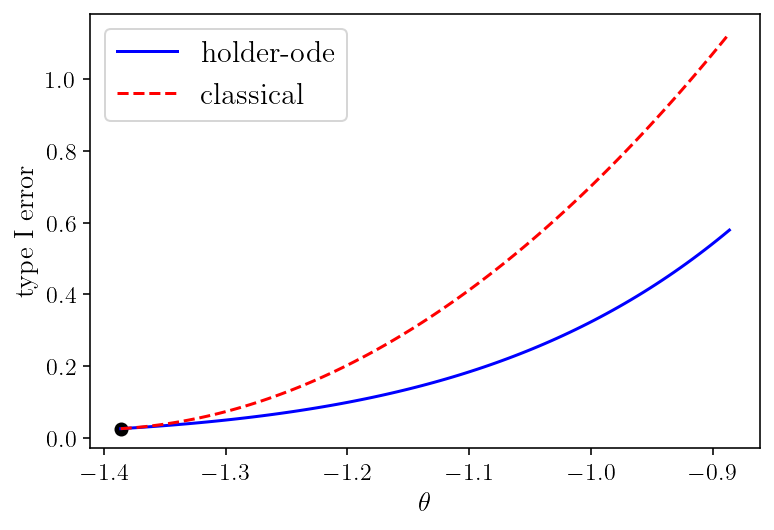

In [89]:
plt.plot([t], [f0], 'ko')
plt.plot(t_path, solution['y'][0,:], 'b-', label='holder-ode')
plt.plot(t_path, classical, 'r--', label='classical')
plt.xlabel(r'$\theta$')
plt.ylabel('type I error')
plt.legend()
plt.show()

In [81]:
idx = np.argmin(solution['y'][0, :] < 0.025)

In [82]:
t_path[idx]

-1.0933650681905975

In [69]:
classical[-1] / solution['y'][0,-1]

DeviceArray(10.35543999, dtype=float64)

In [42]:
solution['y'][0,-1]

0.0035554600275283887